### Approach

-  Load data and analyse the shape
-  Delete columns having all values as null
-  Scan columns one by one and delete the irrelevant columns
-  Fill null values in the remaining columns appropriately
-  Extract derived metrics for dateTime columns - months and years
-  Understand the business meaning of remaining columns
-  Find correlated columns
-  Analyse columns one by one - in isolation using univariate analysis
-  Analyse them with respect to loan status - using segmented univariate and bivariate analysis, depending upon the case
-  Summarise the findings

Please note that going forward I will describe my findings and steps in a highlighted markdown in most cases to differentiate it from the output from the cell code

In [162]:
# import libraries and remove warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [163]:
#upload csv
df = pd.read_csv('loan.csv',low_memory=False)
# check meta info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


`Let's list all the columns and try to make sense what we are given as data`

In [164]:
df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

`There are 111 columns, but we will identify which ones can be useful for our analysis`

#### Data understanding - glancing through columns


We will consider only those column in our analysis which could help us identify risky new loan applications. So we cannot  factor columns which come into picture when the loan becomes active. Just a glance shows a lot of columns which looks irrelevant for our goal.

Column carrying delinquency information like delinq_2yrs, delinq amount, mths_since_last_delinq won't be useful

Information like 
total payment made towards loan(total_pymnt), 
next payment date(next_pymnt_d), 
last payment amount(last_pymnt_amnt), 
last payment date(last_pymnt_d), 
revolving credit balance(revol_bal), 
revolving credit utilization(revol_util), 
open credit lines(open_acc), 
recovered amount(recoveries), 
collection recovery fee (collection_recovery_fee), 
breakdown of principal and interest of the amount paid(total_rec_prncp, total_rec_int, out_prncp), 
Hard inquiries on borrowers credit file(inq_last_6mths), 
last time lending club pulled credit information on borrower's loan(last_credit_pull_d) 
won't be useful for new loan applications so we will delete them

We will find more such columns when we will analyse dataframe chunk by chunk. Let's do the exercise and understand the dataset more


`Remove all columns having all values as NULL`

In [165]:
df.dropna(axis=1, how='all',inplace=True)

`Drop columns which looks irrelevant, but how do we do that? We don't want to loose columns which could prove decisive`

`We will take a glance at data, small chunks at once`

##### We will delete the columns together when we have analyzed all the chunks

In [166]:
df.iloc[0:5,0:15]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified


`id, member_id, emp_title won't help`

`loan_amnt, funded_amnt, funded_amnt_inv looks highly correlated`

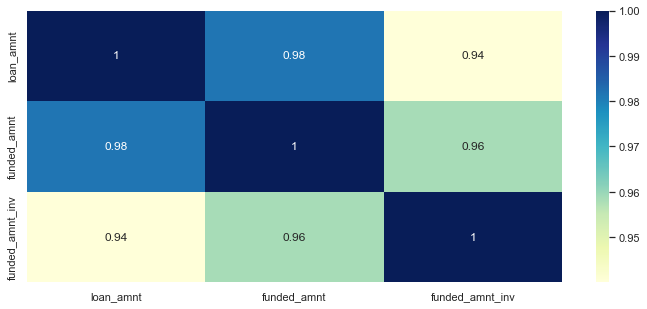

In [167]:
sns.heatmap(df.loc[:,["loan_amnt","funded_amnt","funded_amnt_inv"]].corr(),cmap="YlGnBu", annot=True)

plt.show()


`Our observation seems to be true, we will keep loan_amnt and drop the other two since they won't add extra information`

In [168]:
df.iloc[0:5,15:30]

,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record
0,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN
1,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN
2,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN
3,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN
4,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN


`url, desc, zip_code, earliest_cr_line looks irrelevant. We will drop them as well`

`mths_since_last_delinq, mths_since_last_record shows a lot of null values. Also these won't be helpful since they won't come into effect until loan become active. We cannot use this to predict default in new applications. Let's investigate them anyways`

In [169]:
# Calculating percentage of null values with respect to total values in the column
percent = round((df["mths_since_last_delinq"].isnull().sum()/df.shape[0])*100,2)
print('{0}%'.format(percent))

64.66%


In [170]:
percent = round((df["mths_since_last_record"].isnull().sum()/df.shape[0])*100,2)
print('{0}%'.format(percent))

92.99%


`Anyways, a lot of null values in above couple of columns.`

 `delinq_2yrs, inq_last_6mths won't be helpful to identify default risk in new applications since these metrics come into picture while the loan is running. so we will drop them as well. pymnt_plan also looks repetitive and meaningless. Let's check`

In [171]:
df["pymnt_plan"].value_counts() 

n    39717
Name: pymnt_plan, dtype: int64

In [172]:
df.iloc[0:5,30:45]

,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee
0,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00
1,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11
2,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00
3,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00
4,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00


`since we are going to delete funded_amnt_inv, therefore total_pymnt_inv, out_prncp_inv won't make sense`

`Principals and interest break down columns would also be irrelevant for our goal (out_prncp, total_rec_prncp, total_rec_int), so we will drop these as well `

`Apart from these open_acc, revol_bal, revol_util, total_acc, total_rec_late_fee, recoveries, collection_recovery_fee and  total_pymnt comes won't help for new loan applications, so we will delete them`

`Let's investigate pub_rec, initial_list_status`

In [173]:
df["pub_rec"].value_counts()

0    37601
1     2056
2       51
3        7
4        2
Name: pub_rec, dtype: int64

In [174]:
df["initial_list_status"].value_counts()

f    39717
Name: initial_list_status, dtype: int64

`initial_list_status have same value -> not needed`

`pub_rec almost all values as 0, and rest are negligible. We can delete that as well.`

In [175]:
df.iloc[0:5,45:]

,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,Jan-15,171.62,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,Apr-13,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,Jun-14,649.91,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,Jan-15,357.48,NaN,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,May-16,67.79,Jun-16,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


`irrelevant columns - last_pymnt_d, next_pymnt_d, last_pymnt_amnt, last_credit_pull_d, collections_12_mths_ex_med, acc_now_delinq, chargeoff_within_12_mths, delinq_amnt. Irrelevant since they can't be used to predict behavior for new loan applications since it comes into picture when the loan becomes active. We will delete them`

`suspected irrelevant columns - policy_code, application_type, pub_rec_bankruptcies, tax_liens. We will investigate their values`

In [176]:
df["policy_code"].value_counts()

1    39717
Name: policy_code, dtype: int64

In [177]:
df["application_type"].value_counts()

INDIVIDUAL    39717
Name: application_type, dtype: int64

In [178]:
df["pub_rec_bankruptcies"].value_counts()

0.0    37339
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [179]:
df["tax_liens"].value_counts()

0.0    39678
Name: tax_liens, dtype: int64

`As suspected, all the suspected irrelevant columns either contains same value, or are mostly null, or contain very high amount of same values. For eg pub_rec_bankruptcies have very few non zero values. Let's delete all of them`

`Let's delete all the irrelevant columns together from all the chunks`

In [180]:
# from 1st chunk
col_to_delete1 = ["id", "member_id", "emp_title", "funded_amnt","funded_amnt_inv"]
# from 2nd chunk
col_to_delete2 = ["url", "desc","zip_code", "earliest_cr_line","mths_since_last_delinq", "mths_since_last_record","delinq_2yrs","inq_last_6mths","pymnt_plan"]
# from 3rd chunk
col_to_delete3 = ["funded_amnt_inv", "total_pymnt_inv", "out_prncp_inv","pub_rec", "initial_list_status", "total_rec_late_fee", "recoveries", "collection_recovery_fee","revol_bal","revol_util","total_acc","total_pymnt","total_rec_prncp","total_rec_int","out_prncp","open_acc"]
# from 4th chunk
col_to_delete4 = ["next_pymnt_d", "collections_12_mths_ex_med", "policy_code","application_type", "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "pub_rec_bankruptcies", "tax_liens","last_pymnt_d","last_pymnt_amnt","last_credit_pull_d"]

In [181]:
col_to_delete =  col_to_delete1 + col_to_delete2 + col_to_delete3 + col_to_delete4
col_to_delete

['id',
 'member_id',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'url',
 'desc',
 'zip_code',
 'earliest_cr_line',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'delinq_2yrs',
 'inq_last_6mths',
 'pymnt_plan',
 'funded_amnt_inv',
 'total_pymnt_inv',
 'out_prncp_inv',
 'pub_rec',
 'initial_list_status',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_int',
 'out_prncp',
 'open_acc',
 'next_pymnt_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d']

In [182]:
df.drop(labels=col_to_delete, axis=1, inplace=True)

In [183]:
df.shape

(39717, 16)

`let's check if we need to investigate anything row wise. Let's check all the rows which have at least 5 null values. We can check this by observing df.info() but let's check it programmatically to avoid any manual error`

In [184]:
df[df.isnull().sum(axis=1) > 5].index

Int64Index([], dtype='int64')

`We don't need to drop any rows`

`Let's analyse the most important variable - loan_status`

In [185]:
df["loan_status"].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

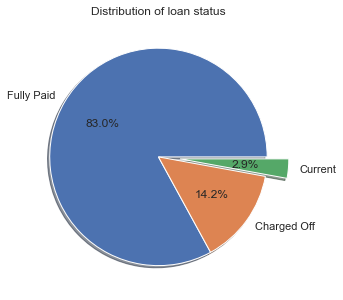

In [186]:
sns.set(rc={'figure.figsize':(8,5)})
plt.pie(df["loan_status"].value_counts(),labels=df["loan_status"].unique(),autopct='%1.1f%%', shadow= True, explode=[0,0,0.2])
plt.title('Distribution of loan status')
plt.show()

`We don't need records with loan status as 'Current', it won't add any value to our analysis whatsoever`

In [187]:
df = df[df["loan_status"] != 'Current']


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  object 
 2   int_rate             38577 non-null  object 
 3   installment          38577 non-null  float64
 4   grade                38577 non-null  object 
 5   sub_grade            38577 non-null  object 
 6   emp_length           37544 non-null  object 
 7   home_ownership       38577 non-null  object 
 8   annual_inc           38577 non-null  float64
 9   verification_status  38577 non-null  object 
 10  issue_d              38577 non-null  object 
 11  loan_status          38577 non-null  object 
 12  purpose              38577 non-null  object 
 13  title                38566 non-null  object 
 14  addr_state           38577 non-null  object 
 15  dti                  38577 non-null 

`Let's try to study title, emp_length ince they have some null values, we will fill the null values by most logical value present in those columns`

In [189]:
df["title"].value_counts()

Debt Consolidation           2090
Debt Consolidation Loan      1620
Personal Loan                 641
Consolidation                 491
debt consolidation            478
                             ... 
Murray Loan                     1
Need debt consolidation!        1
freedom2                        1
DAVE WEDDING                    1
JAL Loan                        1
Name: title, Length: 19297, dtype: int64

`Debt consolidation is the most frequent title, so we will fill the null values with that. We will do carry the same practice while filling the null values in other columns`

In [190]:
values = {"title": "Debt Consolidation"}
df.fillna(values, inplace=True)

In [191]:
df["emp_length"].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

`We can fill the NA values in emp_length by '10+ years' since this is the most commonly occuring value . After that we can convert it to integers`

In [192]:
values = {"emp_length": "10+ years"}
df.fillna(values, inplace=True)

In [193]:
def modify_emp_length(x):
    if x == '10+ years':
        return 10
    elif x == '< 1 year':
        return 0
    else:
        return int(x.split(' ')[0])

df['emp_length'] = df['emp_length'].apply(modify_emp_length)

In [194]:
df["emp_length"].value_counts()

10    9521
0     4508
2     4291
3     4012
4     3342
5     3194
1     3169
6     2168
7     1711
8     1435
9     1226
Name: emp_length, dtype: int64

`pd.DatetimeIndex(df["issue_d"]).month is throwing error " Out of bounds nanosecond timestamp: 1-01-15 00:00:00"`
`We could use pd.to_datetime(df["issue_d"], errors = 'coerce'), but it will convert some values to NAT`
`We will write a custom function to extract month from it. Year can be extracted rather easily`

In [195]:
def convertToMonth(mnth):
    x = mnth.split('-')[0]
    if x == 'Jan':
        return 1
    elif x == 'Feb':
        return 2
    elif x == 'Mar':
        return 3
    elif x== 'Apr':
        return 4
    elif x== 'May':
        return 5
    elif x=='Jun':
        return 6
    elif x == 'Jul':
        return 7
    elif x == 'Aug':
        return 8
    elif x== 'Sep':
        return 9
    elif x == 'Oct':
        return 10
    elif x == 'Nov':
        return 11
    else:
        return 12
    

`Let's handle issue_d (loan issued date) and extract months and years columns from that`

In [196]:
df["issue_m"] = df["issue_d"].apply(convertToMonth)

In [197]:
df["issue_y"] = df["issue_d"].apply(lambda x: int(x.split('-')[1]))

In [198]:
sns.set(rc={'figure.figsize':(6,5)}) # setting the figure size for next set of plots

<AxesSubplot:>

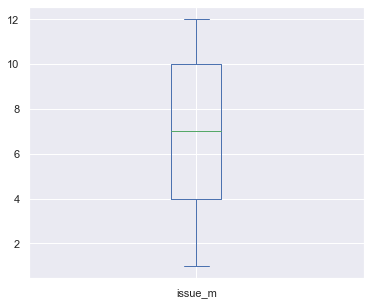

In [199]:
df["issue_m"].plot.box()

<AxesSubplot:>

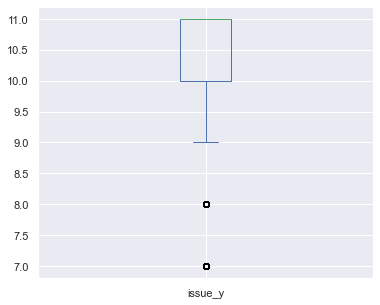

In [200]:
df["issue_y"].plot.box()

`Nothing much to conclude as of now.`

In [201]:
df.drop(labels=["issue_d"],axis=1,inplace=True)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  object 
 2   int_rate             38577 non-null  object 
 3   installment          38577 non-null  float64
 4   grade                38577 non-null  object 
 5   sub_grade            38577 non-null  object 
 6   emp_length           38577 non-null  int64  
 7   home_ownership       38577 non-null  object 
 8   annual_inc           38577 non-null  float64
 9   verification_status  38577 non-null  object 
 10  loan_status          38577 non-null  object 
 11  purpose              38577 non-null  object 
 12  title                38577 non-null  object 
 13  addr_state           38577 non-null  object 
 14  dti                  38577 non-null  float64
 15  issue_m              38577 non-null 

In [203]:
df["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

`Let's covert term values by removing trailing whitespace`

In [204]:
df["term"] = df["term"].apply(lambda x: "36 months" if x == " 36 months" else "60 months") # we could use lstrip as well

In [205]:
df["term"].value_counts()

36 months    29096
60 months     9481
Name: term, dtype: int64

`interest rate needs to be converted to float`

In [206]:
df["int_rate"] = df["int_rate"].apply(lambda x: float(x.rstrip('%')))

In [207]:
df["int_rate"].value_counts()

10.99    913
11.49    790
7.51     787
13.49    749
7.88     725
        ... 
16.96      1
18.36      1
16.15      1
16.01      1
16.20      1
Name: int_rate, Length: 370, dtype: int64

In [208]:
df["loan_status"].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [209]:
df["loan_status"].value_counts()

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  object 
 2   int_rate             38577 non-null  float64
 3   installment          38577 non-null  float64
 4   grade                38577 non-null  object 
 5   sub_grade            38577 non-null  object 
 6   emp_length           38577 non-null  int64  
 7   home_ownership       38577 non-null  object 
 8   annual_inc           38577 non-null  float64
 9   verification_status  38577 non-null  object 
 10  loan_status          38577 non-null  object 
 11  purpose              38577 non-null  object 
 12  title                38577 non-null  object 
 13  addr_state           38577 non-null  object 
 14  dti                  38577 non-null  float64
 15  issue_m              38577 non-null 

### Data understanding - going through important columns
##### So above are the columns that are we going to analyse next. Let's  see what they actually mean

-  loan_amnt - loan amount - self explanatory
-  term - duration of loan. 36 months or 60 months
-  int_rate interest rate - self explanatory
-  grade - Loan classification done by lending club itself based on various consumer attributes like loan replaying capability, credit history etc
-  sub_grade - Further classification of loan grade from 1 to 5
-  emp_length - employement length - for how long the consumer is employed
-  home_ownership - whether consumer has his/her own house, or a mortgaged one, or lives in a rented place
-  verification_status - whether the income source is verified or not by lending club based on bank statements, pay stubs
-  loan_status - current status of loan - paid/running/defaulted
-  title - loan title provided by the borrower - eg personal loan/ home improvement loan
-  purpose - the purpose for which loan was taken by borrower - category provided by borrower
-  addr_state - the state(location) mentioned by borrower in loan application, where they reside
-  dti - debt to income ratio, basically percentage of gross monthly income of borrower that goes towards debt payment
-  issue_m - loan issued month - self explanatory
-  issue_y - loan issued year - self explanatory

`Now let's plot a heatmap of correlation of all columns. It might give us a hint for which column to look into for further analysis`

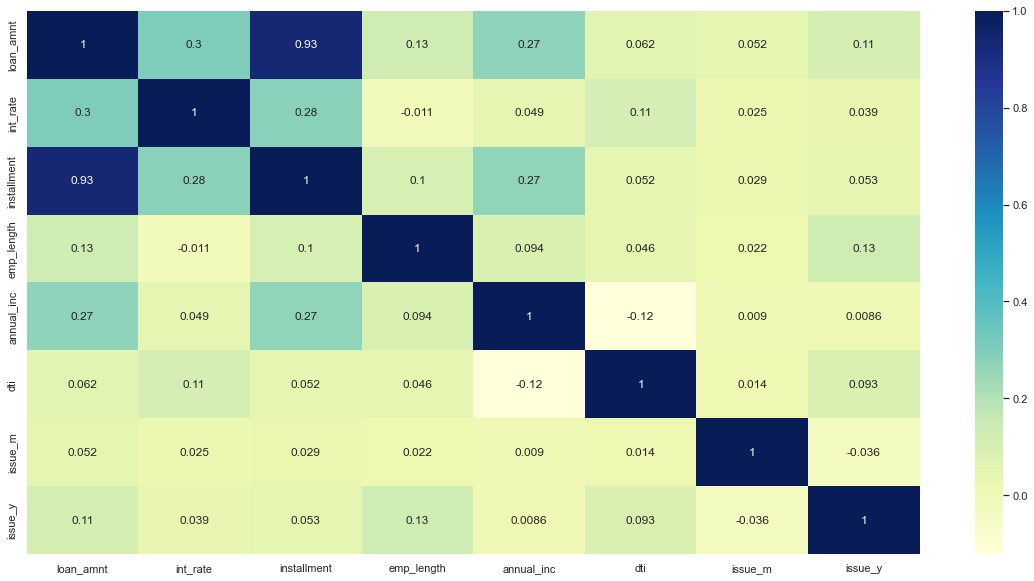

In [211]:
sns.set(rc={'figure.figsize':(20,10)})

corrdf = df.corr()

sns.heatmap(corrdf,cmap="YlGnBu", annot=True)

plt.show()

`loan_amnt and installment are highly correlated. Apart from this there is not much of correlation`


`Let's look at interest rate`

`univariate analysis`

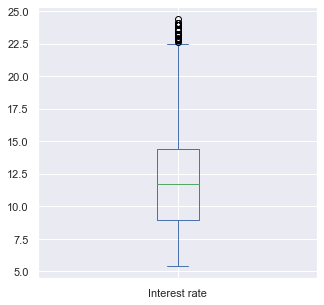

In [212]:
sns.set(rc={'figure.figsize':(5,5)})
df["int_rate"].plot.box()
plt.xticks(ticks=[1],labels=['Interest rate'])
plt.show()

`Let's analyse without outliers`

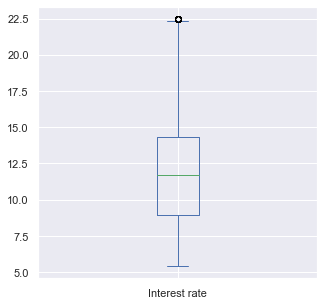

In [213]:
df[df["int_rate"] < 22.5]["int_rate"].plot.box() # values above 22.5 are truncated while plotting box plot
plt.xticks(ticks=[1],labels=['Interest rate'])
plt.show()

`Let's create a copy of dataframe to keep rows without outliers from interest rate and analyse the relation between interest rate and main variable - loan_status`

`Segmented univariate analysis`

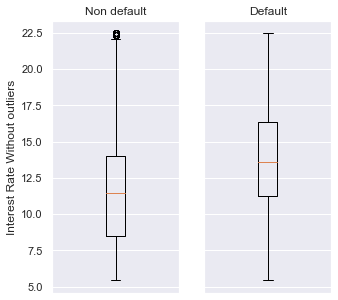

In [214]:
fig, ax = plt.subplots(ncols=2, sharey=True)
intrate_df = df[df["int_rate"] < 22.5] 
ax[0].boxplot(intrate_df[intrate_df["loan_status"] == "Fully Paid"]["int_rate"])
ax[1].boxplot(intrate_df[intrate_df["loan_status"] == "Charged Off"]["int_rate"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Interest Rate Without outliers')
ax[0].set_xticks([]) #removing the xticks as it doesn't make sense here
ax[1].set_xticks([])


plt.show()

`We can clearly see that customers with low interest rate tends to pay off their loan completely while the ones with higher interest rate tends to be defaulters. Median for non defaulters lie somewhere around 11.5-12% but the same for defaulters are somewhere near 13-14%. The interqaurtile range for non-defaulters is around 8 to 14 % whereas for defaulters it is 11 to 16%, which is quite some difference. And as we know, one percent change in interest rate, when compounded over years, could make a huge lot of difference`

`Since we already know that loan amount and installments are correlated with each other from heat map, let's confirm it from a scatter plot`

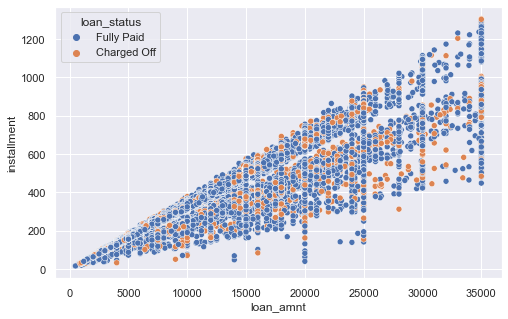

In [215]:
sns.set(rc={'figure.figsize':(8,5)}) 
sns.scatterplot(data = df, x= "loan_amnt",y="installment", hue="loan_status")
new_labels = ['Fully Paid', 'Charged Off']
plt.show()

`We can see here that they are indeed correlated. And the default and non default loans are spread accross the graph so it doesn't look like these factors affects the chances of a loan being default. Let's confirm from segmented univariate analysis of loan category with each of them individually.`

`Let's analyse the loan amount with loan status. We will start with univariate analysis and then move along to segmented univariate analysis`

In [216]:
sns.set(rc={'figure.figsize':(5,5)}) # setting the figure size for next set of plots

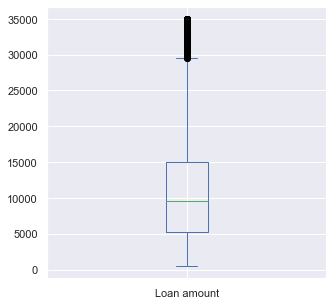

In [217]:
df["loan_amnt"].plot.box()
plt.xticks(ticks=[1],labels=['Loan amount'])
plt.show()

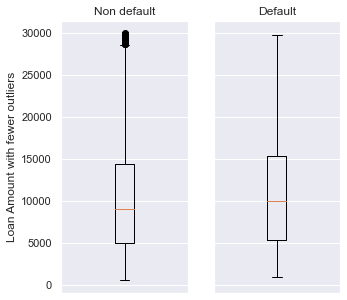

In [218]:
fig, ax = plt.subplots(ncols=2, sharey=True)
# removing the outliers
df_loan_amnt = df[df["loan_amnt"] < 30000]
ax[0].boxplot(df_loan_amnt[df_loan_amnt["loan_status"] == "Fully Paid"]["loan_amnt"])
ax[1].boxplot(df_loan_amnt[df_loan_amnt["loan_status"] == "Charged Off"]["loan_amnt"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Loan Amount with fewer outliers')
ax[0].set_xticks([]) #removing the xticks as it doesn't make sense here
ax[1].set_xticks([])


plt.show()

`As seen, there is not much of difference in the loan amount for defaulters and non defaulters. The interquartile range ended a little higher for defaulters, but median and 25th percentile is almost near by. Not much difference for making any conclusion.`

`Let's start with installments. Univariate and then segmented univariate. We have seen that installments and loan amount were correlated. Since loan amount doesn't affect loan status greatly, this should be the case with installments too.`

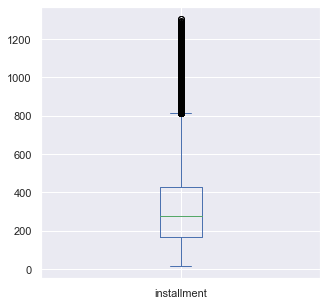

In [219]:
df["installment"].plot.box()
plt.show()

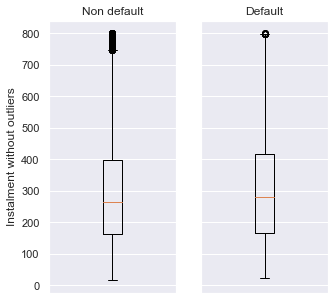

In [220]:
fig, ax = plt.subplots(ncols=2, sharey=True)
# removing the outliers
df_installment = df[df["installment"] < 800]
ax[0].boxplot(df_installment[df_installment["loan_status"] == "Fully Paid"]["installment"])
ax[1].boxplot(df_installment[df_installment["loan_status"] == "Charged Off"]["installment"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Instalment without outliers')
ax[0].set_xticks([]) #removing the xticks as it doesn't make sense here
ax[1].set_xticks([])


plt.show()

`There is not much of difference in installments for defaulters and non defaulters.`

`Let's analyse annual income and its relationship with loan status`

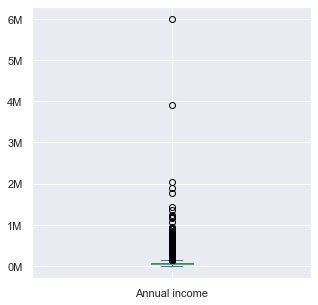

In [221]:
ax = df["annual_inc"].plot.box()
ticks = ax.get_yticks()
ylabels = ["{}M".format(int(i/1000000)) for i in ticks]
# Coverting values on y-axis to Millions
ax.set_yticklabels(ylabels)
plt.xticks(ticks=[1],labels=['Annual income'])
plt.show()

`Let's check without outliers`

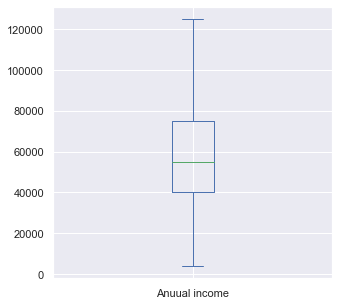

In [222]:
df[df["annual_inc"] < 125000]["annual_inc"].plot.box()
plt.xticks(ticks=[1],labels=['Anuual income'])
plt.show()

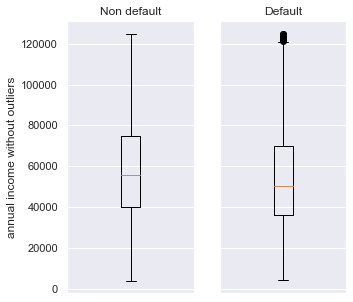

In [223]:
fig, ax = plt.subplots(ncols=2, sharey=True)
# Removing the outliers 
temp_df = df[df["annual_inc"] < 125000]
ax[0].boxplot(temp_df[temp_df["loan_status"] == "Fully Paid"]["annual_inc"])
ax[1].boxplot(temp_df[temp_df["loan_status"] == "Charged Off"]["annual_inc"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('annual income without outliers')
ax[0].set_xticks([]) #removing the xticks as it doesn't make sense here
ax[1].set_xticks([])

plt.show()

`We can see that there is slight difference in the plots. Defaulters tend to have a little lower annual income according to this plot. But the difference is not that big, so we can just conclude that there is not much affect of annual income on loan default`

`Now let's analyse emp_length and its relation with loan status`

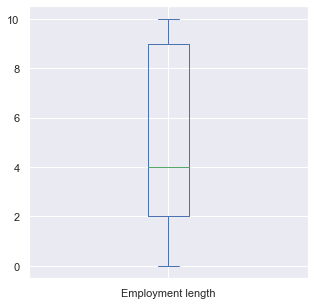

In [224]:
df["emp_length"].plot.box()
plt.xticks(ticks=[1],labels=['Employment length'])
plt.show()

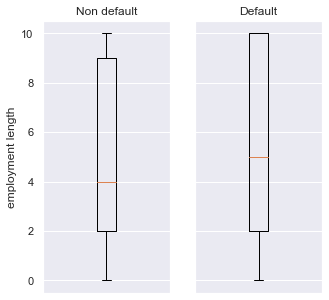

In [225]:
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].boxplot(df[df["loan_status"] == "Fully Paid"]["emp_length"])
ax[1].boxplot(df[df["loan_status"] == "Charged Off"]["emp_length"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('employment length')
ax[0].set_xticks([]) #removing the xticks as it doesn't make sense here
ax[1].set_xticks([])

plt.show()

`Not much of a difference. But, We have condensed all 10+yrs employment to 10, and for default, there is no upper whisker on employment length of people who defaulted. Means a significant amount of people who were long employed defaulted. But the median and overall IQR is not much different, so we can conclude that employment length is not a driving factor here on identifying risky loans`

`Now let's analyse dti and its relation with loan status`

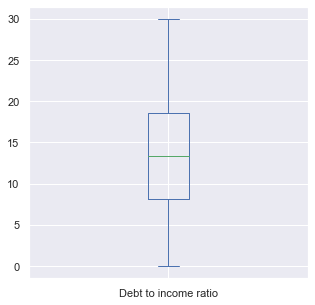

In [226]:
df["dti"].plot.box()
plt.xticks(ticks=[1],labels=['Debt to income ratio'])
plt.show()

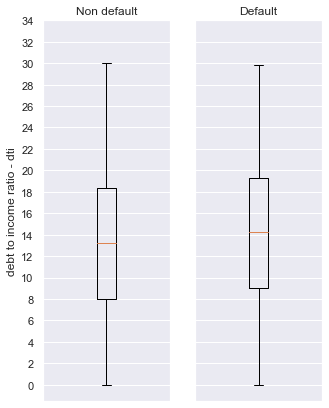

In [227]:
sns.set(rc={'figure.figsize':(5,7)})
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].boxplot(df[df["loan_status"] == "Fully Paid"]["dti"])
ax[1].boxplot(df[df["loan_status"] == "Charged Off"]["dti"])
y = ax[0].get_yticks()
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('debt to income ratio - dti')
# increase the frequency of yticks (0 to max with step as 2) for better reading
plt.yticks(np.arange(0, max(y)+1, 2))
ax[0].set_xticks([]) #removing the xticks as it doesn't make sense here
ax[1].set_xticks([])

plt.show()

`As we see, there is a slight difference in the median and IQR of both the plots, people who defaulted have slightly higher DTI ratio, but again, the difference is not big, so we are not going to conclude anything here.`

In [228]:
df["helper"] = 1 # A helper column to help us measure aggregate for pivot tables

In [229]:
# This function will be used whenever we need to calculate the ratio of default vs non default loans
def cal_ratio(x):
    return (x["Charged Off"]/(x["Charged Off"]+x["Fully Paid"]))*100

In [230]:
### creating fontDict for x and y ticks
### we may use this fonts attributes for some plots going forward wherever and whenever needed
fontdict = {'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'}

`Let's analyse the relationship between categorical variables and loan status`

-  grade
-  sub-grade
-  title
-  purpose
-  address state
-  term type 
-  home ownership
-  verification status

`We will be deriving a new metric called ratio (percentage of defaulted loans to total loans with respect to the different segments for a given category) for which we have already written a function. This will be a kind of bivariate analysis on helper column with loan status and one other categorical variable `

`Let's start analysing grades assigned to the loans`

In [231]:
grades = df["grade"].unique()
print(grades)

['B' 'C' 'A' 'E' 'F' 'D' 'G']


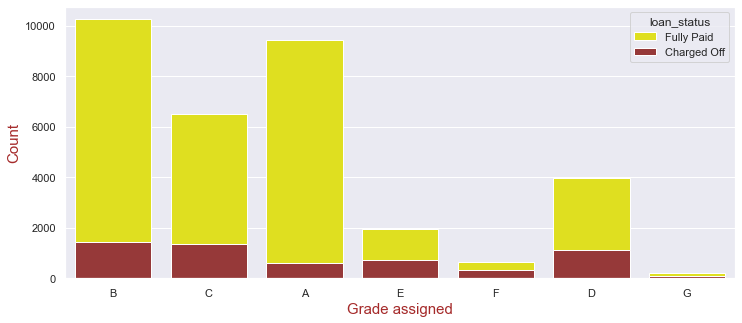

In [232]:
sns.set(rc={'figure.figsize':(12,5)})
palette ={"Charged Off": "brown", "Fully Paid": "yellow"}
sns.countplot(data=df, x= "grade", hue="loan_status", dodge=False,palette=palette)
plt.xlabel('Grade assigned', fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.show()


`Except grade G we have enough sample size for other loan grades`

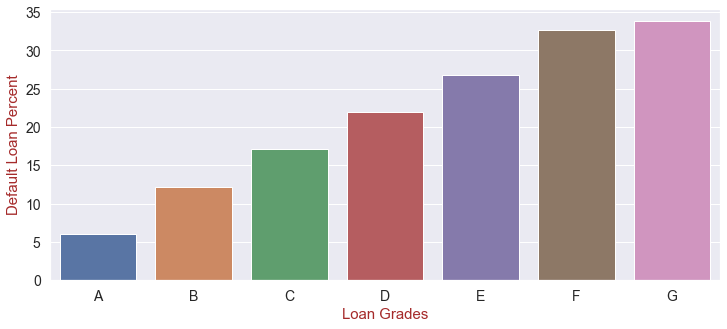

In [233]:
# for each loan grade we are calculating the ratio - count of charged off / total and converting into percentage
pvtGrade = df.pivot_table(index="grade",columns="loan_status",values="helper", aggfunc = lambda x: x.sum())
### while calculating ratio we don't want denominator to be zero has removing the rows from the pivot table where
### either of them can be null
pvtGrade = pvtGrade[(pvtGrade["Charged Off"].notnull()) & (pvtGrade["Fully Paid"].notnull())]
pvtGrade["Ratio"] = pvtGrade.apply(cal_ratio,axis=1)
sns.barplot(data=pvtGrade,y = "Ratio",x = pvtGrade.index )
plt.xlabel("Loan Grades", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

`This is clear indication that default percentage increased from grade A to G, though grade G has small sample size. Nevertheless the pattern is quite evident`

`Let's analyse sub grades`

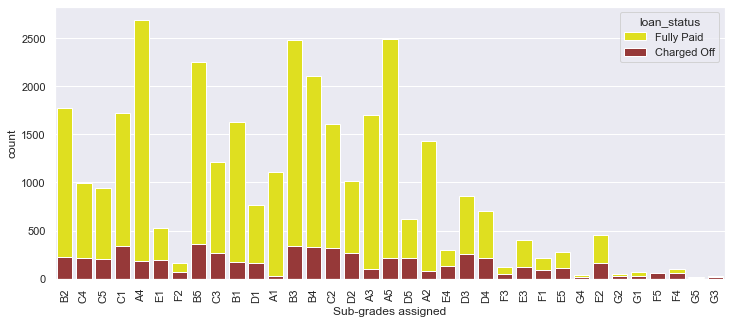

In [234]:
sns.set(rc={'figure.figsize':(12,5)})

sns.countplot(data=df, x= "sub_grade", hue="loan_status", dodge=False,palette=palette)
plt.xlabel('Sub-grades assigned')
plt.xticks(rotation=90)
plt.show()


`The count distribution looked similar to what we saw for grades. Samples size for subgrades under F and G is not much`

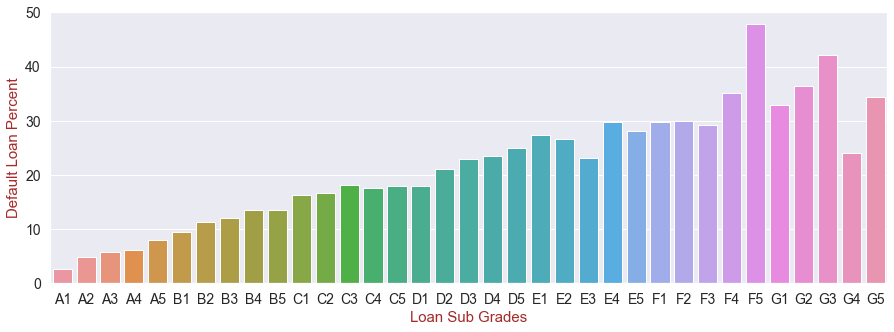

In [235]:
sns.set(rc={'figure.figsize':(15,5)})
pvtSubGrade = df.pivot_table(index="sub_grade",columns="loan_status",values="helper", aggfunc = lambda x: x.sum())
### while calculating ratio we don't want denominator to be zero has removing the rows from the pivot table where
### either of them can be null
pvtSubGrade = pvtSubGrade[(pvtSubGrade["Charged Off"].notnull()) & (pvtSubGrade["Fully Paid"].notnull())]
pvtSubGrade["Ratio"] = pvtSubGrade.apply(cal_ratio,axis=1)
sns.barplot(data=pvtSubGrade,y = "Ratio",x = pvtSubGrade.index )
plt.xlabel("Loan Sub Grades", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

`Sub grades tell the same story as well.Though the sample size starts falling after grade D but still the pattern is same as that of grades. Basically for each grade, the risk or default loan percent increases from sub grade 1 towards 5`

`Let's analyse Loan titles`

In [236]:
pvtTitle = df.pivot_table(index="title",columns="loan_status",values="helper", aggfunc = lambda x: x.sum())
# Picking the loan titles such that they have decent enough sample size for both default and non default
pvtTitle = pvtTitle[(pvtTitle["Charged Off"] > 20) & (pvtTitle["Fully Paid"] > 20)]
titleForConsideration = pvtTitle.index


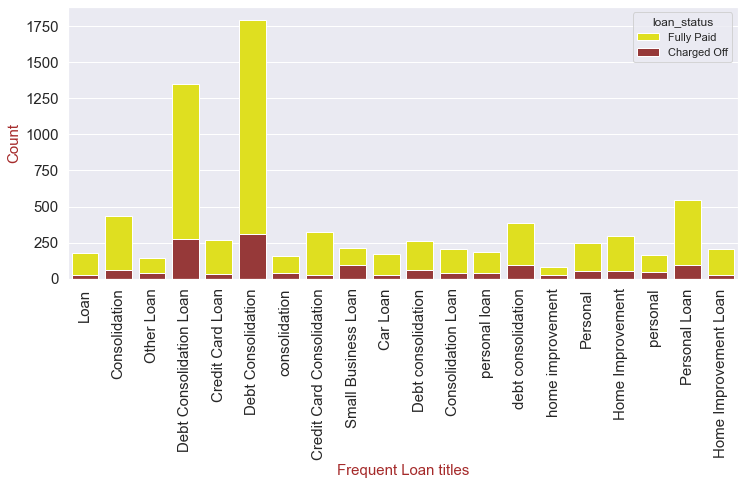

In [237]:
sns.set(rc={'figure.figsize':(12,5)})
# Plotting count per titles from the sample filtered above
palette ={"Charged Off": "brown", "Fully Paid": "yellow"}
sns.countplot(data=df[df["title"].isin(titleForConsideration)], x= "title", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Frequent Loan titles",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()


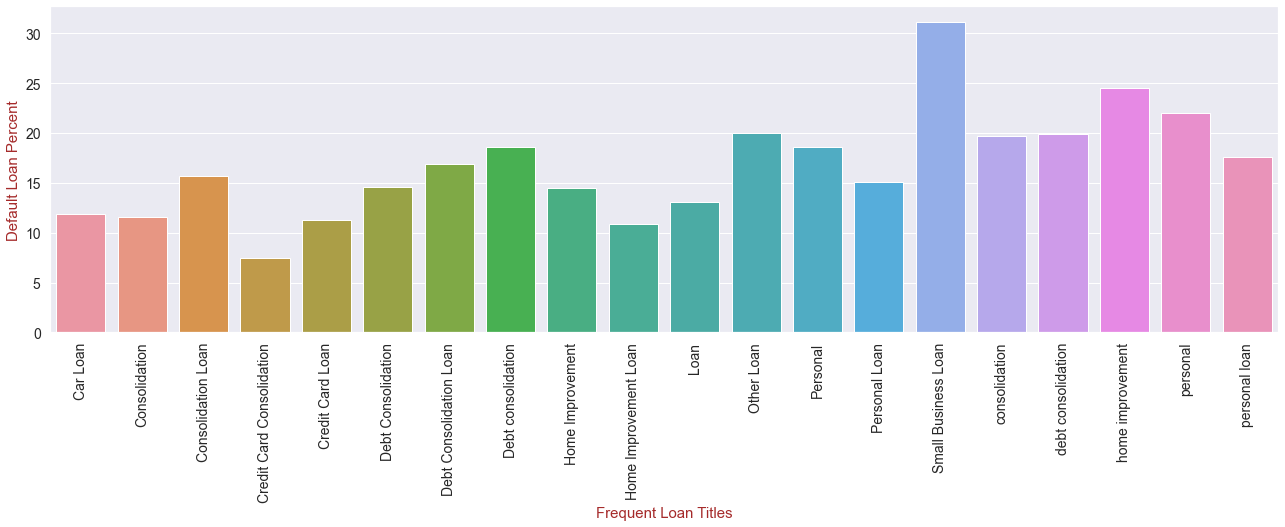

In [238]:
sns.set(rc={'figure.figsize':(22,6)})

pvtTitle["Ratio"] = pvtTitle.apply(cal_ratio,axis=1)
sns.barplot(data=pvtTitle,y = "Ratio",x = pvtTitle.index )
plt.xlabel("Frequent Loan Titles", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.xticks(fontsize=14,rotation=90)
plt.yticks(fontsize=14)
plt.show()

`Looks like a lot of similar loan titles are broken up with little variations. Personal loans are named as personal, Personal and Personal Loan. Other loan titles have similar issues. let's group these variations together and then take the ratio again otherwise whatever inference we could make from above graph won't be correct`

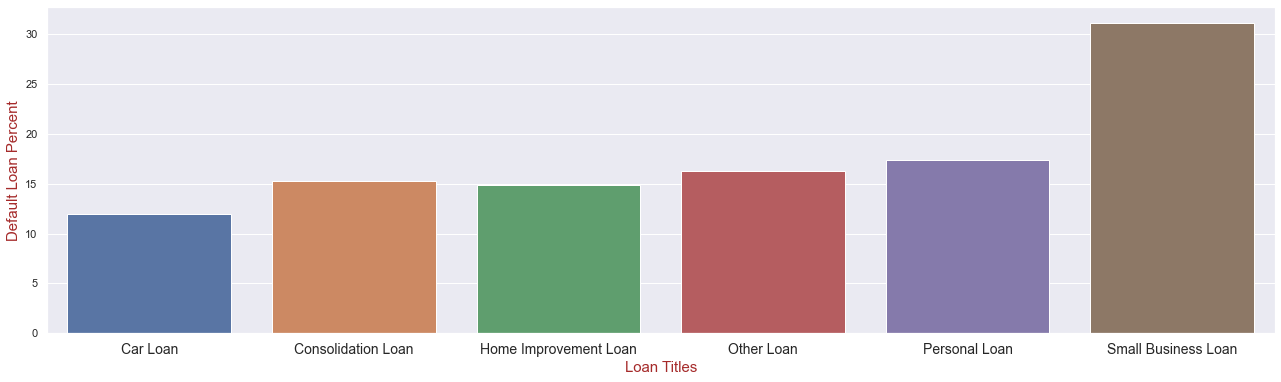

In [239]:
def correctTitles(x):
    if ('consolidation' in x.lower()) or ('debt' in x.lower()) or ('credit card' in x.lower()):
        return 'Consolidation Loan'
    elif 'home improvement' in x.lower():
        return 'Home Improvement Loan'
    elif 'personal' in x.lower():
        return 'Personal Loan'
    elif x == 'Loan':
        return 'Other Loan'
    else:
        return x

# creating a dictionary so that we can map the target title(which we have created in above function) to original title. 
# It will help in renaming the titles in the pivot table index
titleDict = {}

for ind in pvtTitle.index:
    titleDict[ind] = correctTitles(ind)

pvtTitle.rename(index=titleDict,inplace=True)
    
# create another dataframe to hold the aggregated values with similar titles. Please note that ratio had to be recreated since
# summing up of ratios won't make any sense

pvtTitleAgg = pvtTitle.groupby(by=pvtTitle.index).sum()
pvtTitleAgg["Ratio"] = pvtTitleAgg.apply(cal_ratio,axis=1)


sns.barplot(data=pvtTitleAgg,y = "Ratio",x = pvtTitleAgg.index)
plt.xlabel("Loan Titles", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.xticks(fontsize=14)
plt.show()


`Loans taken for small businesses has a lot higher ratio of defaults. This is a crucial point. And suddenly signifies the loan titled as small business are really risky and newer applications for loan titled with same should be approved really carefully`

`Let's analyse the purpose for which loan was taken`

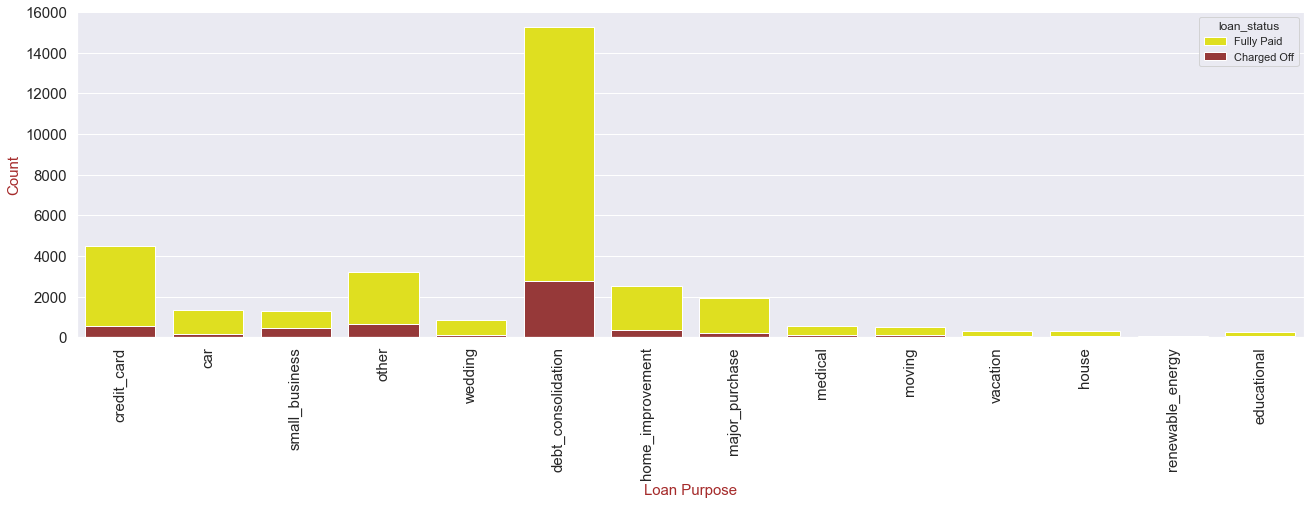

In [240]:

sns.countplot(data=df, x= "purpose", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Loan Purpose",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

`Most loans were taken for the purpose of debt consolidation. Some of the loan purpose doesn't have large enough sample sizes. We will eliminate them while calculating defaulted loan percentages with respect to the purpose of loan `

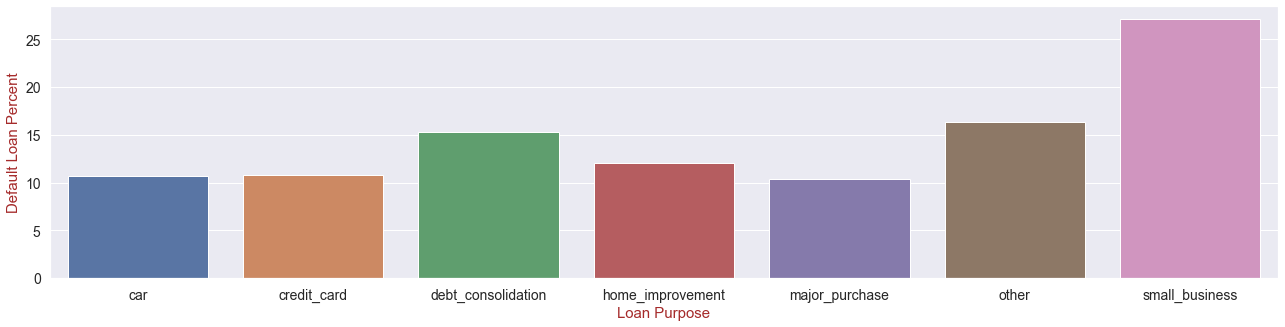

In [241]:
sns.set(rc={'figure.figsize':(22,5)})
pvtPurpose = df.pivot_table(index="purpose",columns="loan_status",values="helper", aggfunc = lambda x: x.sum())
### while calculating ratio we don't want denominator to be zero has removing the rows from the pivot table where
### either of them can be null
pvtPurpose = pvtPurpose[(pvtPurpose["Charged Off"].notnull()) & (pvtPurpose["Fully Paid"].notnull())]
### remove the small samples so that ratio won't be skewed
pvtPurpose = pvtPurpose[(pvtPurpose["Charged Off"] + pvtPurpose["Fully Paid"] > 1250)]

pvtPurpose["Ratio"] = pvtPurpose.apply(cal_ratio,axis=1)

sns.barplot(data=pvtPurpose,y = "Ratio",x = pvtPurpose.index )
plt.xlabel("Loan Purpose", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

`Loans taken for small businesses tend to get default. The reason could be small businesses could be risky and they couldn't make profit and hence defaulted. A thing to consider while approving new loan applications`

`Next we will analyse loans taken with respect to state address`

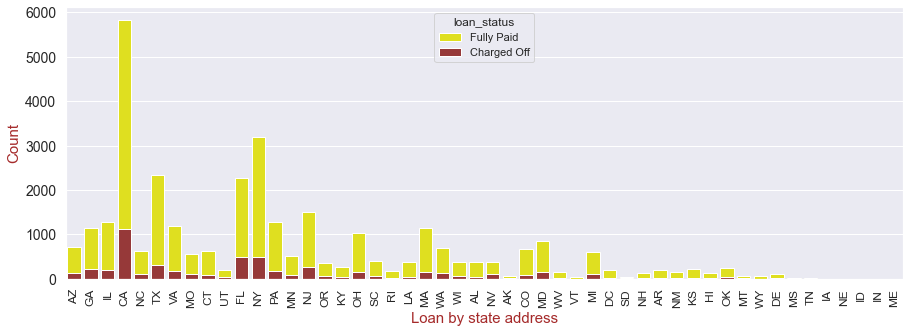

In [242]:

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(data=df, x= "addr_state", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Loan by state address",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14)
plt.show()

`Most of the states have very small sample size. We will analyse states only if the sample size is at least 500 including both default and non default loans`

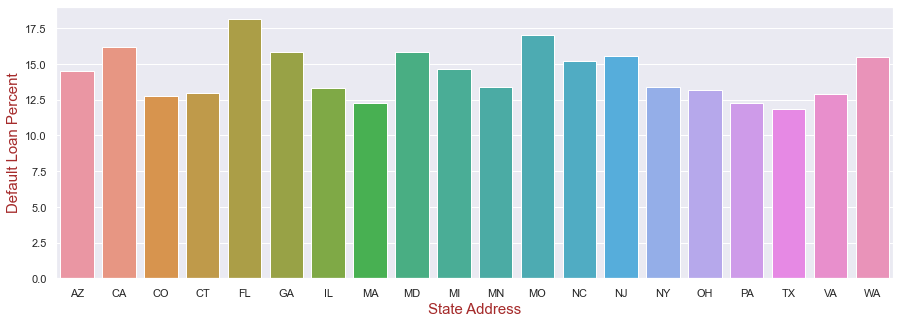

In [243]:

pvtState = df.pivot_table(index="addr_state",columns="loan_status",values="helper", aggfunc = lambda x: x.sum())
### while calculating ratio we don't want denominator to be zero has removing the rows from the pivot table where
### either of them can be null
pvtState = pvtState[(pvtState["Charged Off"].notnull()) & (pvtState["Fully Paid"].notnull())]
pvtState = pvtState[(pvtState["Charged Off"] + pvtState["Fully Paid"] > 500)]

pvtState["Ratio"] = pvtState.apply(cal_ratio,axis=1)

sns.barplot(data=pvtState,y = "Ratio",x = pvtState.index )
plt.xlabel("State Address", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)

plt.show()

`Consumers belonging to Missouri(MO) and Florida(FL) have defaulted more on their loans. Loan applications coming from these states should be more scrutinized and should be approved carefully since this looks like one of the driving factors for identifying risky loans`

`Now let's move forward towards analysing the loan term type`

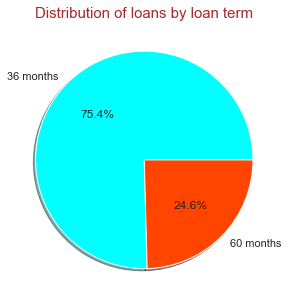

In [244]:
sns.set(rc={'figure.figsize':(8,5)})
colors = ['cyan', 'orangered'] #choosing the colors of our liking to create more contrast
plt.pie(df["term"].value_counts(),labels=df["term"].unique(),autopct='%1.1f%%',colors = colors, shadow= True)
plt.title('Distribution of loans by loan term',fontdict=fontdict)
plt.show()

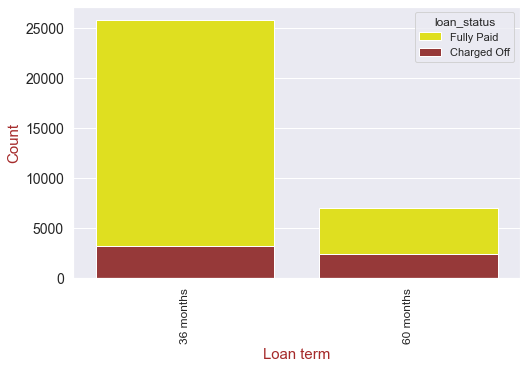

In [245]:
sns.set(rc={'figure.figsize':(8,5)})
sns.countplot(data=df, x= "term", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Loan term",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14)
plt.show()


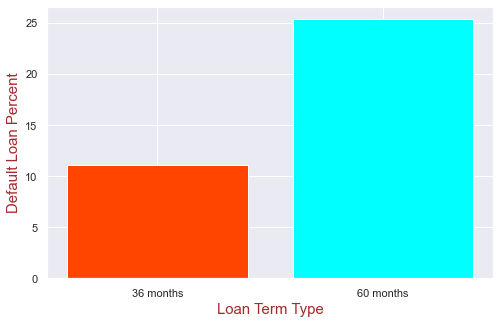

In [246]:
fig, ax = plt.subplots(ncols=1)
pvtTerm = df.pivot_table(index="term", columns = "loan_status", values="helper", aggfunc = lambda x: x.sum())
pvtTerm["Ratio"] = pvtTerm.apply(cal_ratio,axis=1)
ax.bar(data=pvtTerm, x= pvtTerm.index, height = "Ratio",color=['orangered','cyan'])

plt.xlabel("Loan Term Type", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.show()

`Loan with long term (60 months) has much higher default ratio as compared to short term loans. This looks one of the strong driving factors for defaulted loans.`

`Let's analyse loan by the home ownership`

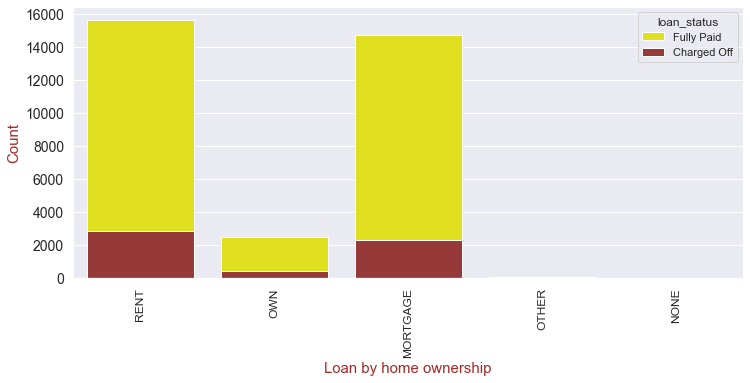

In [247]:
sns.set(rc={'figure.figsize':(12,5)})
sns.countplot(data=df, x= "home_ownership", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Loan by home ownership",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14)
plt.show()


`Home ownerhip type 'other' and 'none' has a very small sample size, so we will exclude it while calculating the default loan percent`

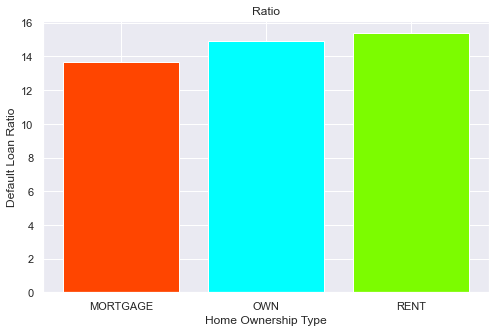

In [248]:
sns.set(rc={'figure.figsize':(8,5)})
fig, ax = plt.subplots(ncols=1)
pvthome = df.pivot_table(index="home_ownership", columns = "loan_status", values="helper", aggfunc = lambda x: x.sum())
pvthome["Ratio"] = pvthome.apply(cal_ratio,axis=1)
# remove 'others' and 'none' from our calculation
pvthome = pvthome[~pvthome.index.isin(['OTHER','NONE'])]
ax.bar(data=pvthome, x=pvthome.index, height = "Ratio",color=['orangered','cyan','lawngreen'])
ax.set_title("Ratio")
ax.set_xlabel("Home Ownership Type")
ax.set_ylabel("Default Loan Ratio")
plt.show()

`There is not much of a correlation between home ownership type and loan status`

`Let's analyse loan status with respect to consumer's income verification`

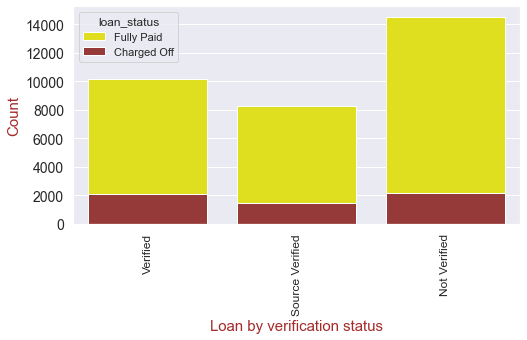

In [249]:
sns.set(rc={'figure.figsize':(8,4)})
sns.countplot(data=df, x= "verification_status", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Loan by verification status",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14)
plt.show()


`'Verified' and 'Source Verified' looks same, so we will group them together`

In [250]:
df["verification_status"] = df["verification_status"].apply(lambda x : "Not Verified" if x == "Not Verified" else "Verified")
df["verification_status"].value_counts()

Verified        21883
Not Verified    16694
Name: verification_status, dtype: int64

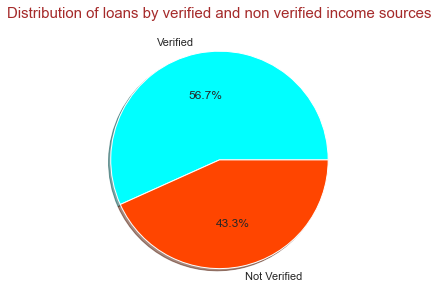

In [251]:
sns.set(rc={'figure.figsize':(8,5)})
colors = ['cyan', 'orangered']
plt.pie(df["verification_status"].value_counts(),labels=df["verification_status"].unique(),autopct='%1.1f%%',colors = colors, shadow= True)
plt.title('Distribution of loans by verified and non verified income sources',fontdict=fontdict)
plt.show()

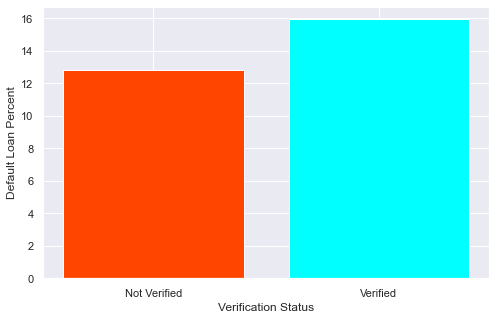

In [252]:
fig, ax = plt.subplots(ncols=1)
# creating pivot table for measuring default loan percentage
pvtver = df.pivot_table(index="verification_status", columns = "loan_status", values="helper", aggfunc = lambda x: x.sum())
pvtver["Ratio"] = pvtver.apply(cal_ratio,axis=1)
ax.bar(data=pvtver, x= pvtver.index, height = "Ratio",color=['orangered','cyan'])
ax.set_xlabel("Verification Status")
ax.set_ylabel("Default Loan Percent")
plt.show()

`There is definite difference in the default percentage, but it is not much (13:16). We can say there is a weak relationship between verification status and loan status but not conclusive enough`

`Now let's analyse the months columns(derived metric) from different date columns`


In [253]:
# Create utility months list to help in labelling x axis ticks
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

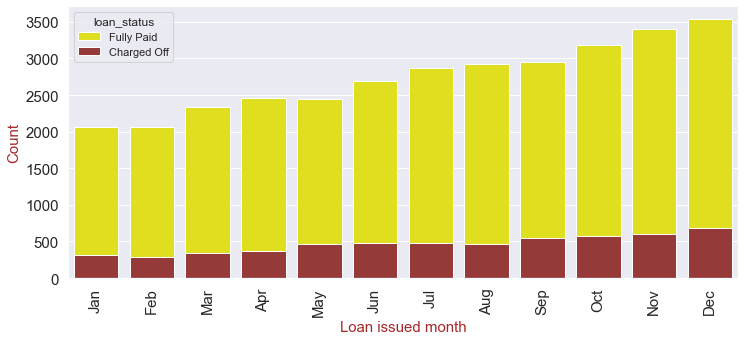

In [254]:
sns.set(rc={'figure.figsize':(12,5)})
sns.countplot(data=df, x= "issue_m", hue="loan_status", dodge=False,palette=palette)
plt.xlabel("Loan issued month",fontdict=fontdict)
plt.ylabel("Count", fontdict=fontdict)
# we will replace xticks locations by months labels we created in above cell
plt.xticks(np.arange(0,12,step=1), months,rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

`Interesting pattern isn't it - the count of laons approvals increases from Jan to Dec with few exceptions. But it won't help us to identify drivers. so it is interesting but not useful enough`

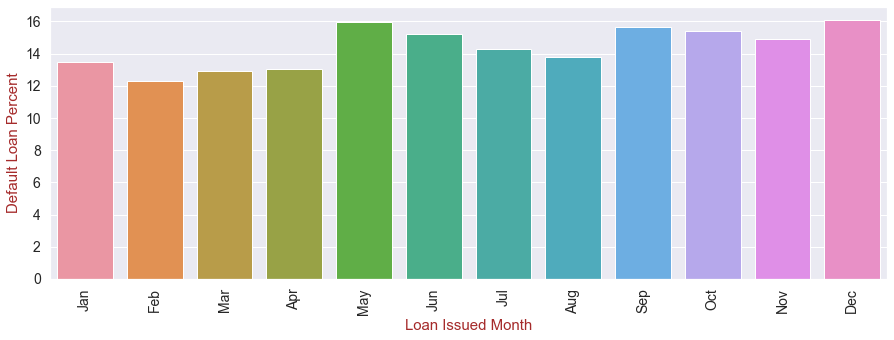

In [255]:
sns.set(rc={'figure.figsize':(15,5)})
pvtLoanMonth = df.pivot_table(index="issue_m",columns="loan_status",values="helper", aggfunc = lambda x: x.sum())
pvtLoanMonth = pvtLoanMonth[(pvtLoanMonth["Charged Off"].notnull()) & (pvtLoanMonth["Fully Paid"].notnull())]
pvtLoanMonth["Ratio"] = pvtLoanMonth.apply(cal_ratio,axis=1)
sns.barplot(data=pvtLoanMonth,y = "Ratio",x = pvtLoanMonth.index )
plt.xlabel("Loan Issued Month", fontdict=fontdict)
plt.ylabel("Default Loan Percent", fontdict=fontdict)
plt.xticks(np.arange(0,12,step=1), months,rotation=90, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

`So from May onwards the default percentage increases just a bit. We don't the reason behind this, but for new loan applications coming in May and Dec, the LC should be careful in approving them `

In [256]:
sns.set(rc={'figure.figsize':(8,5)}) # setting the figure size for next set of plots

`Now let's analyse year related derived column`

`Loan issued year`

In [257]:
df["issue_y"].value_counts()

11    20516
10    11532
9      4716
8      1562
7       251
Name: issue_y, dtype: int64

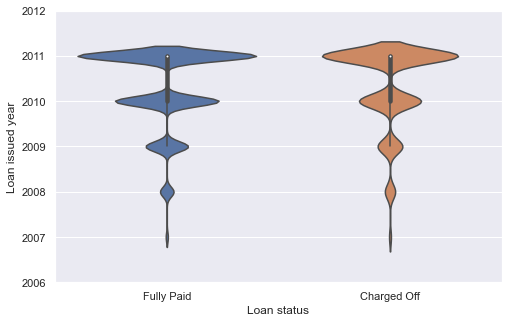

In [258]:
#function to convert year to full year display (like 6 to 2006)
def yearsAxisDisplay(year):
    return 2000+int(year)

fig, ax = plt.subplots(ncols=1, sharey=True)
sns.violinplot(data=df, x="loan_status", y="issue_y",ax=ax)

ax.set_ylabel('Loan issued year')

ax.set_xlabel('Loan status')

locs,texts = plt.yticks()
plt.yticks(locs,list(map(yearsAxisDisplay, locs))) # converting yticks points to labels of our choice i.e. years
plt.show()

`Loans taken in 2007 and 2008 has very small sample size, so we will remove it from our analysis`

`Let's try to find if loan issued year has some thing to do with defaults. Ofcourse even if it does and we don't know the reason behind it, it is difficult to use this factor for future analysis`

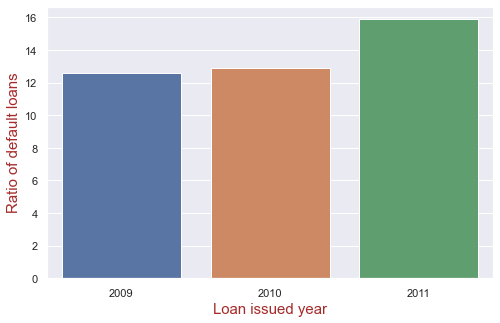

In [259]:
pvtLoanYear = df.pivot_table(index="issue_y",columns="loan_status",values ="helper",aggfunc = lambda x:x.sum())
pvtLoanYear["Ratio"] = pvtLoanYear.apply(cal_ratio,axis=1)
#Removing the loan issued years 2007 and 2008 since their sample size is small (check violin plots)
pvtLoanYear = pvtLoanYear[~pvtLoanYear.index.isin([7,8])]
sns.barplot(data=pvtLoanYear,y = "Ratio",x = pvtLoanYear.index )
plt.ylabel("Ratio of default loans",fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("Loan issued year", fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'})
locs, texts = plt.xticks()
#each element in text will be of the form (x,y,text) so we need to get the text
labels = [int(text.get_text()) for text in texts]
plt.xticks(locs,list(map(yearsAxisDisplay, labels))) # converting xticks points to labels of our choice i.e. years
plt.show()

`There is something about loan issued in year 2011. It has the most percentage of loan defaults as compared to the previous years. But we cannot use it for predicting future default loans since we don't know the reason behind why 2011 has most default loan frequency and whether it is a pattern`

## Findings and recommendations

-  `Loans with high interest rate tend to get defaulted more. Since interest rate compounds and overall repayment amount gets big exponentially over time, loans given at lower interest rate could be safer.`
-  `Long term loan(60 months) tends to get default. Applications for long term loan should be more scrutinized.`
-  `Lending club assigned loan grades based on consumers' attributes is very useful. The default frequency increases from grade A towards G, this loan applications going from A towards G should be approved very carefully.`
-  `In a particular grade, the default frequency increases from 1 to 5 subgrades with exceptions. But as a general thumb of rule, the higher subgrade increases the chances of default.`
-  `Loans titled 'Small business loan' are risky and should be approved carefully understanding that the chances of default could be high.`
-  `Loans taken for the purpose of small businesses are risky as we know from the title of the loans as well. Loan with this purpose should be approved understanding the amount of risk involved.`
-  `Consumers belonging to Missouri(MO) and Florida(FL) have defaulted more on their loans. Loan applications with consumers from these states should be more scrutinized`
-  `As late as the month is issued in a US fiscal year, the chances of default increases. Loan applications coming late in the fiscal year cycle should be approved carefully. Specially May and December`
